# Map 2D data

This notebook will have the algorithm for how to map 2D data using the (george package)[https://george.readthedocs.io/en/latest/]. 

>An example of doing this is present in https://gist.github.com/shoyer/80aa06f5ad44aacd9187 (using an older version of george).

The main steps are: 

In [1]:
# Load appropriate modules
import george
import numpy as np


In [ ]:
#1 Generate 2D data (e.g. could be a 2D function like : sin (x+y) + error ),with some prescribed parameters.
#  -- Alternatively, we could just use a test data set that I have for this step that has data that 
#  -- is a function of (lat, lon, time), like the Argo data will be.

In [372]:
# Create a pretend argo data field

from scipy import stats
import pandas as pd

lat = stats.uniform(10, 40).rvs(50)
lon = stats.uniform(70, 80).rvs(50)
time = pd.date_range('01-01-2015','04-01-2015',50)

X = np.array([lon,lat]).T

yerr = 0.2 * np.ones_like(a)

temp = np.sin(lat)+np.sin(lon)+yerr  # play dataset

Text(0.5, 0, 'lat')

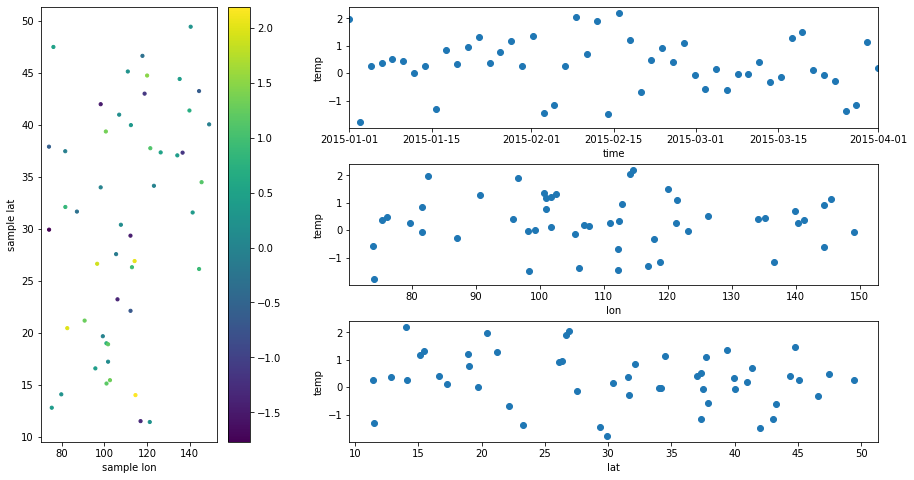

In [373]:
fig,ax=plt.subplots(1,2,figsize=(15,8))
grid = plt.GridSpec(3, 3, wspace=0.4, hspace=0.3)
ax1=plt.subplot(grid[:, 0])
ax2=plt.subplot(grid[0, 1:])
ax3=plt.subplot(grid[1, 1:])
ax4=plt.subplot(grid[2, 1:])

cs=ax1.scatter(lon,lat,s=10,c=temp)
plt.colorbar(cs,ax=ax1)
ax1.set_xlabel('sample lon')
ax1.set_ylabel('sample lat')

ax2.scatter(time,temp)
#ax2.errorbar(time, temp, yerr=yerr, fmt=".k", capsize=0)

ax2.set_ylabel('temp')
ax2.set_xlabel('time')
ax2.set_xlim(time[0],time[-1])

ax3.scatter(lon,temp)
ax3.set_ylabel('temp')
ax3.set_xlabel('lon')
#ax2.set_xlim(time[0],time[-1])

ax4.scatter(lat,temp)
ax4.set_ylabel('temp')
ax4.set_xlabel('lat')



In [ ]:
#2 Use george to model this as a GP
#  -- Decide which kernel to use


# Assume local stationarity following W&S 2018 

# Tried with sci-kit learn

In [ ]:
# scikit learn

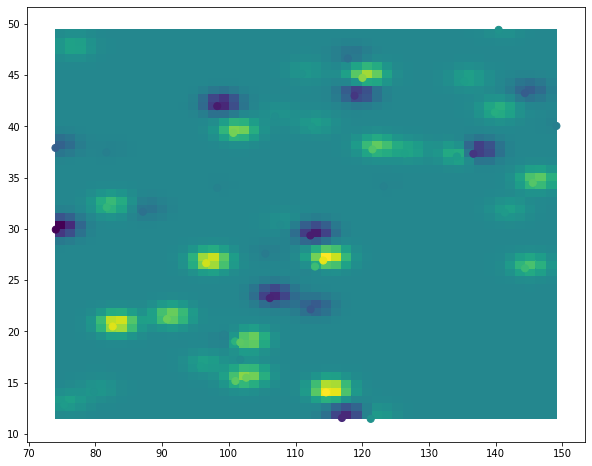

In [375]:
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

# Input space

x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

y = temp

kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)

ax.scatter(lon,lat,s=50,c=temp)

plt.show()

In [ ]:
#2 Use george to model this as a GP
#  -- Decide which kernel to use


# Assume local stationarity following W&S 2018 

In [ ]:
# Kernels

In [321]:

#kernel1 = kernels.LocalGaussianKernel(location=6.0,log_width=3)

(2, 50)


[]

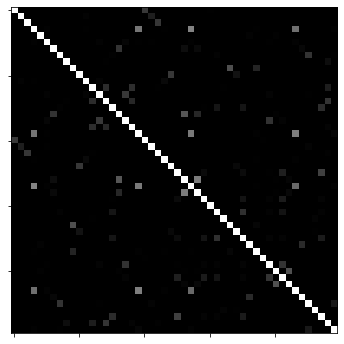

In [291]:
# Visualise Kernel

x = np.ndarray([2,50])
print(x.shape)
k = kernel.get_value(np.atleast_2d(x).T)
pl.figure(figsize=(6, 6))
pl.imshow(k, cmap="gray", interpolation="nearest")
pl.gca().set_xticklabels([])
pl.gca().set_yticklabels([])

In [271]:
x1 = (lat)
x2 = (lon)
y = temp

In [292]:
x=np.array([lon,lat])

In [266]:
x.shape

(2, 50)

In [293]:
#kernel = np.var(y) * kernels.ExpSquaredKernel(0.5)

gp = george.GP(kernel)
gp.compute(np.atleast_2d(x).T, yerr)

In [294]:
gp

In [279]:
x_pred = np.array([np.linspace(70,80,150),np.linspace(10,40,150)])

(2, 150)

In [295]:
#x_pred = [np.linspace(70,80,150),np.linspace(10,40,150)]
pred, pred_var = gp.predict(y, x_pred.T, return_var=True)

(150,)

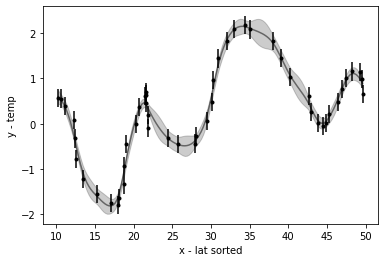

In [171]:
plt.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
plt.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
plt.errorbar(x1, y, yerr=yerr, fmt=".k", capsize=0)
#pl.plot(x_pred, np.sin(x_pred), "--g")
#pl.xlim(0, 10)
#pl.ylim(-1.45, 1.45)
plt.xlabel("x - lat sorted")
plt.ylabel("y - temp");

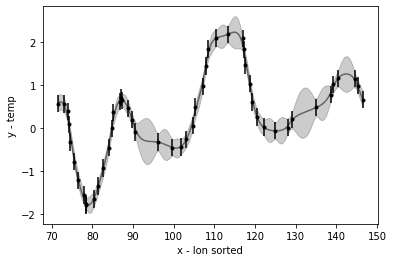

In [172]:
gp.compute(x2, yerr)
x_pred2 = np.linspace(x2.min(), x2.max(), 150)
pred2, pred_var2 = gp.predict(y, x_pred2, return_var=True)

plt.fill_between(x_pred2, pred2 - np.sqrt(pred_var2), pred2 + np.sqrt(pred_var2),
                color="k", alpha=0.2)
plt.plot(x_pred2, pred2, "k", lw=1.5, alpha=0.5)
plt.errorbar(x2, y, yerr=yerr, fmt=".k", capsize=0)
#pl.plot(x_pred, np.sin(x_pred), "--g")
#pl.xlim(0, 10)
#pl.ylim(-1.45, 1.45)
plt.xlabel("x - lon sorted")
plt.ylabel("y - temp");

In [ ]:
#3 Learn the hyper parameters using MLE (can be done in george)

In [176]:
from scipy.optimize import minimize

def neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.log_likelihood(y)

def grad_neg_ln_like(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y)

result = minimize(neg_ln_like, gp.get_parameter_vector(), jac=grad_neg_ln_like)
print(result)

gp.set_parameter_vector(result.x)
print("\nFinal ln-likelihood: {0:.2f}".format(gp.log_likelihood(y)))

      fun: 17.590533385502518
 hess_inv: array([[1, 0],
       [0, 1]])
      jac: array([ 2.63980871e-06, -6.80624229e-07])
  message: 'Optimization terminated successfully.'
     nfev: 1
      nit: 0
     njev: 1
   status: 0
  success: True
        x: array([0.15663303, 4.03372865])

Final ln-likelihood: -17.59


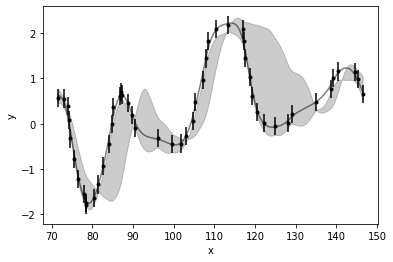

In [177]:
pred2, pred_var2 = gp.predict(y, x_pred2, return_var=True)

pl.fill_between(x_pred2, pred2 - np.sqrt(pred_var2), pred + np.sqrt(pred_var2),
                color="k", alpha=0.2)
pl.plot(x_pred2, pred2, "k", lw=1.5, alpha=0.5)
pl.errorbar(x2, y, yerr=yerr, fmt=".k", capsize=0)
#pl.plot(x_pred, np.sin(x_pred), "--g")
#pl.xlim(0, 10)
#pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

In [191]:
c=np.array([pred,pred2])
c.shape

(2, 150)

ValueError: 'c' argument has 2 elements, which is not acceptable for use with 'x' with size 22500, 'y' with size 22500.

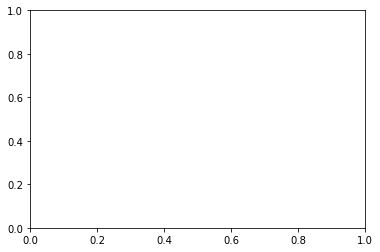

In [185]:
ln,lt=np.meshgrid(x_pred2,x_pred)
plt.scatter(ln,lt,c=[pred,pred2])

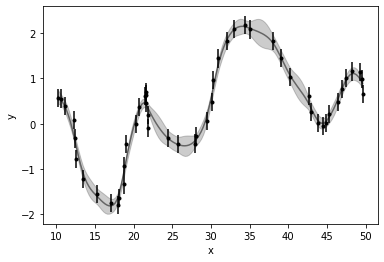

In [166]:
pred, pred_var = gp.predict(y, x_pred, return_var=True)

pl.fill_between(x_pred, pred - np.sqrt(pred_var), pred + np.sqrt(pred_var),
                color="k", alpha=0.2)
pl.plot(x_pred, pred, "k", lw=1.5, alpha=0.5)
pl.errorbar(x, y, yerr=yerr, fmt=".k", capsize=0)
#pl.plot(x_pred, np.sin(x_pred), "--g")
#pl.xlim(0, 10)
#pl.ylim(-1.45, 1.45)
pl.xlabel("x")
pl.ylabel("y");

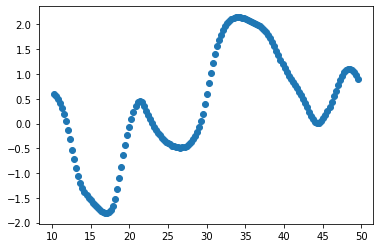

In [167]:
plt.scatter(x_pred,pred)

In [153]:
gp = george.GP(kernel1, mean=np.mean(y), fit_mean=True,
               white_noise=np.log(0.19**2), fit_white_noise=True)
gp.compute(x)
print(gp.log_likelihood(y))
print(gp.grad_log_likelihood(y))

-22.40288265701767
[ 0.41231337  1.03668038 -0.11052183 -0.25909813]


In [154]:
import scipy.optimize as op

# Define the objective function (negative log-likelihood in this case).
def nll(p):
    gp.set_parameter_vector(p)
    ll = gp.log_likelihood(y, quiet=True)
    return -ll if np.isfinite(ll) else 1e25

# And the gradient of the objective function.
def grad_nll(p):
    gp.set_parameter_vector(p)
    return -gp.grad_log_likelihood(y, quiet=True)

# You need to compute the GP once before starting the optimization.
gp.compute(x)

# Print the initial ln-likelihood.
print(gp.log_likelihood(y))

# Run the optimization routine.
p0 = gp.get_parameter_vector()
results = op.minimize(nll, p0, jac=grad_nll, method="L-BFGS-B")

# Update the kernel and print the final log-likelihood.
gp.set_parameter_vector(results.x)
print(gp.log_likelihood(y))

-22.40288265701767
-22.31760230010194


In [29]:
x

array([1.9151945 , 2.72592605, 2.76464255, 3.5781727 , 3.70250755,
       4.37727739, 5.00995126, 6.22108771, 6.83462935, 7.12702027,
       7.79975808, 7.85358584, 8.01872178, 8.75932635, 9.58139354])

ValueError: operands could not be broadcast together with shapes (100,) (15,) 

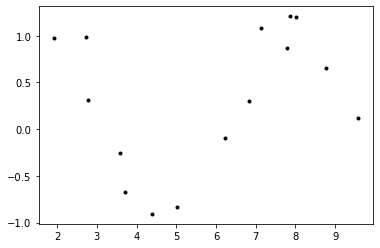

In [39]:
t = np.linspace(max(x), 25, 100)
mu, var = gp.predict(y, x, return_var=True)
std = np.sqrt(var)

pl.plot(x, y, ".k")
pl.fill_between(t, mu+std, mu-std, color="g", alpha=0.5)


In [ ]:
# With sci-kit learn

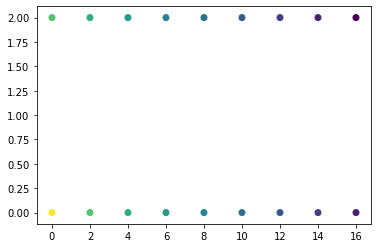

In [306]:
plt.scatter(X[:,0],X[:,1],c=y)

/Users/isabelle/opt/anaconda3/lib/python3.7/site-packages/sklearn/gaussian_process/_gpr.py:370: UserWarning: Predicted variances smaller than 0. Setting those variances to 0.
  warnings.warn("Predicted variances smaller than 0. "


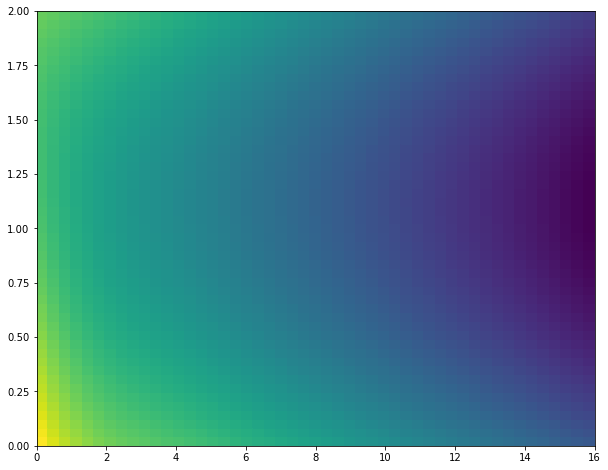

In [352]:
from itertools import product
import numpy as np
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C

X = np.array([[0,0],[2,0],[4,0],[6,0],[8,0],[10,0],[12,0],[14,0],[16,0],[0,2],
                    [2,2],[4,2],[6,2],[8,2],[10,2],[12,2],[14,2],[16,2]])

y = np.array([-54,-60,-62,-64,-66,-68,-70,-72,-74,-60,-62,-64,-66,
                    -68,-70,-72,-74,-76])

# Input space
x1 = np.linspace(X[:,0].min(), X[:,0].max()) #p
x2 = np.linspace(X[:,1].min(), X[:,1].max()) #q
x = (np.array([x1, x2])).T

kernel = C(1.0, (1e-3, 1e3)) * RBF([5,5], (1e-2, 1e2))
gp = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=15)

gp.fit(X, y)

x1x2 = np.array(list(product(x1, x2)))
y_pred, MSE = gp.predict(x1x2, return_std=True)

X0p, X1p = x1x2[:,0].reshape(50,50), x1x2[:,1].reshape(50,50)
Zp = np.reshape(y_pred,(50,50))

# alternative way to generate equivalent X0p, X1p, Zp
# X0p, X1p = np.meshgrid(x1, x2)
# Zp = [gp.predict([(X0p[i, j], X1p[i, j]) for i in range(X0p.shape[0])]) for j in range(X0p.shape[1])]
# Zp = np.array(Zp).T

fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111)
ax.pcolormesh(X0p, X1p, Zp)

plt.show()

In [ ]:
#4 Map the data using the learned parameters. 
# (How did the mapping do compared to the original data?)

In [ ]:
#5 Add mean field and mapped anomaly field together and plot